# <font style="color:rgb(50,120,229)">Motivation </font>
In the previous chapter, we used a Multilayer Perceptron on the Fashion MNIST dataset. The performance was pretty good as we achieved 88% accuracy on test data. But there was a problem with that approach. In our training dataset, all images are centered. If the images in the test set are off-center, then the MLP approach fails miserably. We want the network to be Translation-Invariant.

Given below is an example of the first test image which corresponds to the `Boot` class. The image is shifted by some amount to the top and bottom. The classifier predicts it correctly for the centered image but fails in the other two cases. To make it work for these images, either we have to train separate MLPs for different locations or we have to make sure that we have all these variations in the training set as well, which I would say is difficult, if not impossible.

<img src="https://www.learnopencv.com/wp-content/uploads/2019/12/mlp-shift-failure.jpg" width="900">

The Fully connected network tries to learn global features or patterns. It acts as a good classifier.

Another major problem with a fully connected classifier is that the number of parameters increases very fast since each node in layer L is connected to a node in layer L-1. So it is not feasible to design very deep networks using an MLP structure alone.

Both the above problems are solved to a great extent by using Convolutional Neural Networks.

## <font style="color:rgb(50,120,229)">Import Libraries </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

## <font style="color:rgb(50,120,229)">Import the Data</font>
We will use the fashion MNIST load_data function to load it into memory

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
labelMap = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

## <font style="color:rgb(50,120,229)">Explore the Data</font>
Check out the number of images in training and test data and also the number of classes and some sample images

In [4]:
from tensorflow.keras.utils import to_categorical

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 9')

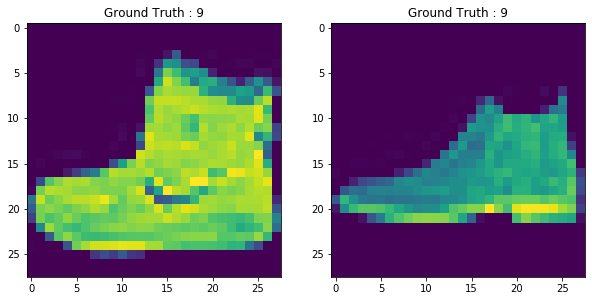

In [5]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:])
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:])
plt.title("Ground Truth : {}".format(test_labels[0]))


## <font style="color:rgb(50,120,229)">Preprocess the Data</font>
Perform normalization of data (i.e. convert the images to float and normalize the intensity values to lie between 0-1 and convert the labels to categorical variables to be used in Keras.

In [6]:
# Find the shape of input images and create the variable input_shape
nDims = 1
nRows,nCols = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols,nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols,nDims)
input_shape = (nRows, nCols,nDims)

# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [7]:
# Display the change for category label using one-hot encoding
print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

Original label 0 :  9
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## <font style="color:rgb(50,120,229)">Define the Model</font>
For implementing a CNN, we will stack up Convolutional Layers, followed by Max Pooling layers. We will also include Dropout to avoid overfitting. 

Finally, we will add a fully connected ( Dense ) layer followed by a softmax layer. Given below is the model structure.

We use 6 convolutional layers and 1 fully-connected layer. 
- The first 2 convolutional layers have 32 filters / kernels with a window size of 3×3. 
- The remaining conv layers have 64 filters. 
- We also add a max pooling layer with window size 2×2 after each pair of conv layer. 
- We add a dropout layer with a dropout ratio of 0.25 after every pooling layer. 
- In the final line, we add the dense layer which performs the classification among 10 classes using a softmax layer.

In [8]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

## <font style="color:rgb(50,120,229)">Train the model</font>
We will employ the same Keras workflow that we learnt in the previous section. We create the model and use the `compile` and `fit` methods to train the network.

If we check the model summary we can see the shapes of each layer.

It shows that since we have used padding in the first layer, the output shape is same as the input ( 32×32 ). But the second conv layer shrinks by 2 pixels in both dimensions. Also, the output size after pooling layer decreases by half since we have used a stride of 2 and a window size of 2×2. The final droupout layer has an output of 2x2x64. This has to be converted to a single array. This is done by the flatten layer which converts the 3D array into a 1D array of size 2x2x64 = 256. The final layer has 10 nodes since there are 10 classes.

Since it is a 10 class classification problem, we will use a categorical cross entropy loss and use RMSProp optimizer to train the network. We will run it for 20 epochs.

In [9]:
model1 = createModel()
batch_size = 256
epochs = 20
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [10]:
history = model1.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_data, test_labels_one_hot))
# test_loss,test_accuracy = model1.evaluate(test_data, test_labels_one_hot)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 43s 712us/sample - loss: 0.9351 - accuracy: 0.6424 - val_loss: 0.5806 - val_accuracy: 0.7685
Epoch 2/20
60000/60000 [==============================] - 41s 691us/sample - loss: 0.5269 - accuracy: 0.8019 - val_loss: 0.5359 - val_accuracy: 0.8076
Epoch 3/20
60000/60000 [==============================] - 41s 689us/sample - loss: 0.4226 - accuracy: 0.8460 - val_loss: 0.3797 - val_accuracy: 0.8584
Epoch 4/20
60000/60000 [==============================] - 41s 689us/sample - loss: 0.3654 - accuracy: 0.8665 - val_loss: 0.3887 - val_accuracy: 0.8491
Epoch 5/20
60000/60000 [==============================] - 41s 690us/sample - loss: 0.3247 - accuracy: 0.8823 - val_loss: 0.3015 - val_accuracy: 0.8920
Epoch 6/20
60000/60000 [==============================] - 41s 686us/sample - loss: 0.3024 - accuracy: 0.8916 - val_loss: 0.2781 - val_accuracy: 0.9000
Epoch 7/20
60000/60000 [====================

## <font style="color:rgb(50,120,229)">Check the loss and accuracy curves</font>
We use the history method while training to store the accuracy and loss values over the iterations. We plot the values to see how the network accuracy and loss changed while training.

Text(0.5, 1.0, 'Loss Curves')

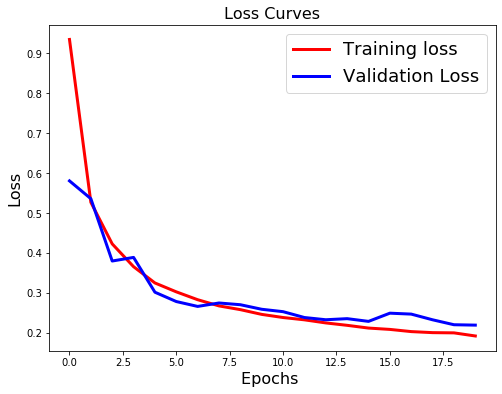

In [11]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

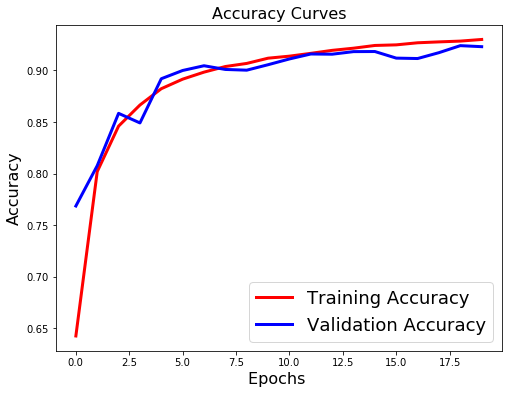

In [12]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


From the above curves, we can see that there is a considerable difference between the training and validation loss. This indicates that the network has tried to memorize the training data and thus, is able to get better accuracy on it. This is a sign of Overfitting. But we have already used Dropout in the network, then why is it still overfitting. We will see if we can further reduce overfitting using something else.

## <font style="color:rgb(50,120,229)">Inference</font>
Now that the model has trained and we are getting a decent accuracy on the test set, we should check the results visually too. 

Let us check what output we got for the first test image.

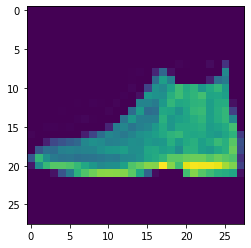

Label = 9, Item = Ankle boot


In [13]:
testSample = test_data[0,:]
plt.imshow(testSample.reshape(28,28));plt.show()

label = model1.predict_classes(testSample.reshape(1,28,28,nDims))[0]
print("Label = {}, Item = {}".format(label,labelMap[label]))

### <font style="color:rgb(8,133,37)">Now let us also check the output of the image that is shifted up</font>

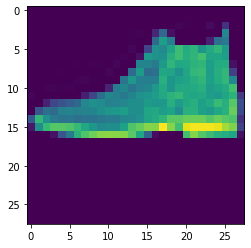

Label = 9, Item = Ankle boot


In [14]:
shiftUp = np.zeros(testSample.shape)
shiftUp[1:20,:] = testSample[6:25,:]
plt.imshow(shiftUp.reshape(28,28));plt.show()

label = model1.predict_classes(shiftUp.reshape(1,28,28,nDims))[0]
print("Label = {}, Item = {}".format(label,labelMap[label]))

It shows that the output is correct even when the image is shifted up.

### <font style="color:rgb(8,133,37)">And for the image that is shifted Down?</font>

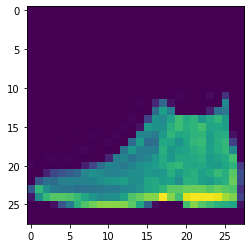

Label = 9, Item = Ankle boot


In [15]:
shiftDown = np.zeros(testSample.shape)
shiftDown[10:27,:] = testSample[6:23,:]
plt.imshow(shiftDown.reshape(28,28));plt.show()

label = model1.predict_classes(shiftDown.reshape(1,28,28,nDims))[0]
print("Label = {}, Item = {}".format(label,labelMap[label]))

### <font style="color:rgb(8,133,37)">Voila! The network is translation invariant now!</font>

## <font style="color:rgb(50,120,229)">Exercise </font>
1. Use the CIFAR10 dataset instead of Fashion MNIST and see what changes you need to make to the code
2. Train it for extended periods and see what changes occur from the curves.

It looks like there were a lot of parameters to chose from and then training took a long time. We would not want to get tied down with these two problems when we are working on simple problems. Many researchers working in this field very generously open-source their trained models which have been trained on millions of images and for hundreds of hours on many GPUs. We can leverage their models and try to use their trained models as the starting point rather than starting from scratch. We will learn how to do Transfer Learning and Fine-tuning and how to use your own data for training the network in the next week.